In [263]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [251]:
import math
import os.path

import keras
import librosa.feature
import sklearn

import pandas
import numpy
from matplotlib import pyplot as plt

import urbansound8k
import preprocess

In [252]:
data = urbansound8k.load_dataset()
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


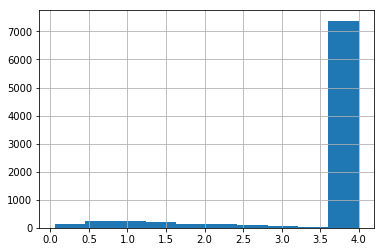

In [253]:
(data.end - data.start).hist()

In [254]:
(data.end-data.start).mode()

0    4.0
dtype: float64

In [255]:
folds, test = urbansound8k.folds(data)
len(folds), folds[0][0].shape, folds[0][1].shape, test.shape

(9, (7022, 8), (873, 8), (837, 8))

In [388]:
# PicakCNN used 950ms, 41 frames for short-frame variant. 50% overlap
def sample_windows(length, frame_samples, window_frames, overlap=0.5):
    """Split @samples into a number of windows of samples
    with length @frame_samples * @window_frames
    """
    ws = frame_samples * window_frames
    start = 0
    while start < length:
        end = min(start + ws, length)
        yield start, end
        start += (ws * (1-overlap))

def test_windows_shorter_than_window():
    frame_samples=256
    window_frames=64
    fs=16000
    length = 0.4*fs
    w = list(sample_windows(int(length), frame_samples, window_frames))
    assert len(w) == 1, len(w)
    assert w[-1][1] == length

def test_window_typical():
    frame_samples=256
    window_frames=64
    fs=16000
    length = 4.0*fs
    w = list(sample_windows(int(length), frame_samples, window_frames))
    assert len(w) == 8, len(w) 
    assert w[-1][1] == length
    
test_windows_shorter_than_window()
test_window_typical()    
    
frame_samples=256
window_frames=72
fs=16000
w_ms = (frame_samples*window_frames/fs)
print('window size', w_ms)
w = list(sample_windows(int(4.0*fs), frame_samples=frame_samples, window_frames=window_frames))
print(w[-2][1] - w[-2][0], w[-1][1] - w[-1][0])
w

window size 1.152
17920.0 8704.0


[(0, 18432),
 (9216.0, 27648.0),
 (18432.0, 36864.0),
 (27648.0, 46080.0),
 (36864.0, 55296.0),
 (46080.0, 64000),
 (55296.0, 64000)]

cutting 7752 samples shorter than 1.0 seconds
37064


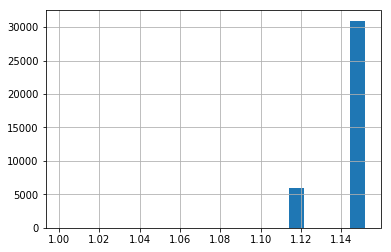

In [521]:
def expand_training_set(samples, frame_samples, window_frames,
                        sample_rate=16000, cut_length=1.0, augmentations=0):
    chunks = {
        'slice_file_name': [],
        'fold': [],
        'classID': [],
        'start': [],
        'end': [],
        'augmentation': [],
    }
    
    for (index, sample) in samples.iterrows():
        duration = sample.end - sample.start
        length = int(sample_rate * duration)
        
        for aug in range(-1, augmentations):
        
            for win in sample_windows(length, frame_samples, window_frames):
                start, end = win
                chunks['slice_file_name'].append(sample.slice_file_name)
                chunks['fold'].append(sample.fold)
                # to assume class is same as that of parent sample maybe a bit optimistic
                # not certain that every chunk has content representative of class
                # alternative would be multi-instance learning
                chunks['classID'].append(sample.classID) 
                chunks['start'].append(start/sample_rate)
                chunks['end'].append(end/sample_rate)
                chunks['augmentation'].append(None if aug == -1 else aug)
            
    df = pandas.DataFrame(chunks)
    
    if cut_length:
        w = (df.end-df.start > cut_length)
        cleaned = df[w]
        print('cutting {} samples shorter than {} seconds'.format(len(df) - len(cleaned), cut_length))
    
    return cleaned

        
df = expand_training_set(folds[0][0], frame_samples=frame_samples, window_frames=window_frames)
print(len(df))
(df.end-df.start).hist(bins=20)  

In [664]:
settings = dict(
    samplerate=16000,
    n_mels=32,
    fmin=0,
    fmax=8000,
    n_fft=512,
    hop_length=256,
    augmentations=5,
)

def load_sample(sample, window_frames=72):
    n_mels = settings['n_mels']
    sample_rate = settings['samplerate']
    hop_length = settings['hop_length']
    
    # Load precomputed features
    aug = None
    if hasattr(sample, 'augmentation'):
        aug = sample.augmentation
    folder = os.path.join('aug', preprocess.settings_id(settings, feature='mels'))
    path = preprocess.feature_path(sample, out_folder=folder, augmentation=aug)
    mels = numpy.load(path)['arr_0']
    assert mels.shape[0] == n_mels, mels.shape
    
    # Cut out the relevant part
    start = int(sample.start * (sample_rate / hop_length))
    end = int(sample.end * (sample_rate / hop_length))
    d = (sample.end-sample.start)
    mels = mels[:, start:end]
    #assert mels.shape[1] > 0, (sample)

    if mels.shape[1] > 0:
        mels = librosa.core.power_to_db(mels, top_db=80, ref=numpy.max)
    
    # zero-pad window to standard length
    if window_frames is None:
        padded = mels
    else:
        padded = numpy.full((n_mels, window_frames), 0)    
        inp = mels[:, 0:min(window_frames, mels.shape[1])]
        padded[:, 0:inp.shape[1]] = inp

    # add channel dimension
    data = numpy.expand_dims(padded, -1)
    return data
    
load_sample(df.iloc[5]).shape

(32, 72, 1)

In [666]:

def gen(X, Y, loader, batchsize=10, n_classes=10):
    
    assert len(X) == len(Y), 'X and Y must be equal length'
    assert len(X) % batchsize == 0, 'input length must be divisible by @batchsize'
        
    sample_idx = 0
    while True:
        batch_data = []
        batch_labels = []

        if sample_idx >= len(X):
            sample_idx = 0
        
        while len(batch_data) < batchsize:
            data = loader(X.iloc[sample_idx])  
            y = Y.iloc[sample_idx]
            y = keras.utils.to_categorical(y, num_classes=n_classes)
            batch_data.append(data)
            batch_labels.append(y)
            sample_idx += 1
            
        batch = (numpy.stack(batch_data), numpy.stack(batch_labels))
        yield batch

fold = df
import itertools
g = gen(fold[0:16], fold.classID[0:16], loader=load_sample, batchsize=8)
batches = list(itertools.islice(g, 16))
len(batches), batches[0][0].shape, batches[0][1].shape

(16, (8, 32, 72, 1), (8, 10))

In [663]:
import dense
import sbcnn
import dilated

def build_model():

    #model = dilated.build_model(bands=32, frames=72, channels=1, kernels=[32,32,32,32])
    model = sbcnn.build_model(bands=32, frames=72, channels=1, pool=(3,3))
    #model = dense.build_model(bands=32, frames=72, channels=1, pooling='avg',
    #                          dropout=0.5, growth=30, reduction=0.5)
    return model

build_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_163 (Conv2D)          (None, 32, 72, 24)        240       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 10, 24, 24)        0         
_________________________________________________________________
activation_229 (Activation)  (None, 10, 24, 24)        0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 10, 24, 48)        10416     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 3, 8, 48)          0         
_________________________________________________________________
activation_230 (Activation)  (None, 3, 8, 48)          0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 1, 6, 48)          20784     
__________

In [670]:
def train_model(name, fold, train_samples=35000, val_samples=3000, batch_size=200, epochs=50, seed=1):
    
    model = build_model()
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(lr=3e-4),
                  metrics=['accuracy'])

    train = expand_training_set(fold[0], frame_samples=frame_samples, window_frames=window_frames,
                                augmentations=0)
    val = expand_training_set(fold[1], frame_samples=frame_samples, window_frames=window_frames)

    train = train.sample(train_samples, replace=False, random_state=seed)
    val = val.sample(val_samples, replace=False, random_state=seed)

    model_name = name+'.e{epoch:02d}-v{val_loss:.2f}.model.hdf5'
    checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_acc', mode='max',
                                         period=1, verbose=1, save_best_only=False)
    callbacks_list = [checkpoint]

    train_gen = gen(train, train.classID, loader=load_sample, batchsize=batch_size)
    val_gen = gen(val, val.classID, loader=load_sample, batchsize=batch_size)

    hist = model.fit_generator(train_gen, validation_data=val_gen,
                        steps_per_epoch=math.ceil(len(train)/batch_size),
                        validation_steps=math.ceil(len(val)/batch_size),
                        callbacks=callbacks_list,
                        epochs=epochs, verbose=1)
    
    return hist
    
h = train_model("test", folds[0], epochs=1, train_samples=20, val_samples=20, batch_size=5)

cutting 7752 samples shorter than 1.0 seconds
cutting 947 samples shorter than 1.0 seconds
Epoch 1/1
4/4 [==============================] - 19s 5s/step - loss: 6.7605 - acc: 0.1000 - val_loss: 3.3963 - val_acc: 0.0000e+00

Epoch 00001: saving model to test.model.01-3.40.hdf5


In [679]:
h.epoch, h.history

([0],
 {'val_loss': [3.396274149417877],
  'val_acc': [0.0],
  'loss': [6.7605085372924805],
  'acc': [0.10000000149011612]})

In [689]:
def history_dataframe(h):
    data = {}
    data['epoch'] = h.epoch
    for k, v in h.history.items():
        data[k] = v
    df = pandas.DataFrame(data)
    return df
    
history_dataframe(h)

,epoch,val_loss,val_acc,loss,acc
0,0,3.396274,0.0,6.760509,0.1


In [690]:
def run_experiment(name):
    
    for fold_no, fold_data in enumerate(folds):
        model_name = "{}.f{}".format(name, fold_no)
        hist = train_model(model_name, fold_data,
                           epochs=1, train_samples=20, val_samples=20, batch_size=10)
        df = history_dataframe(hist)
        df.to_csv(model_name+'.history.csv')

run_experiment("first")
        

KeyboardInterrupt: 

In [654]:
model = keras.models.load_model('sbcnn.hdf5')
model

In [655]:
import collections

def predict_windowed(model, samples, method='mean'):
    sample_rate = settings['samplerate']
    Sample = collections.namedtuple('Sample', 'start end fold slice_file_name')

    out = []
    for _, sample in samples.iterrows():
        duration = sample.end - sample.start
        length = int(sample_rate * duration)
        windows = []
        
        for win in sample_windows(length, frame_samples, window_frames):
            chunk = Sample(start=win[0]/sample_rate,
                           end=win[1]/sample_rate,
                           fold=sample.fold,
                           slice_file_name=sample.slice_file_name)    
            d = load_sample(chunk)
            windows.append(d)

        inputs = numpy.stack(windows)
        inputs = numpy.expand_dims(inputs, axis=-1)
        predictions = model.predict(inputs)

        if method == 'mean':
            p = numpy.mean(predictions, axis=0)
            assert len(p) == 10
            out.append(numpy.argmax(p))
        elif method == 'majority':
            votes = numpy.argmax(predictions, axis=1)
            p = numpy.argmax(numpy.bincount(votes))
            out.append(p)

    return numpy.stack(out)

from sklearn.metrics import accuracy_score

t = test[0:10]
mean_m = predict_windowed(model, t, method='mean')
accuracy_score(t.classID, mean_m)

0.7025089605734767

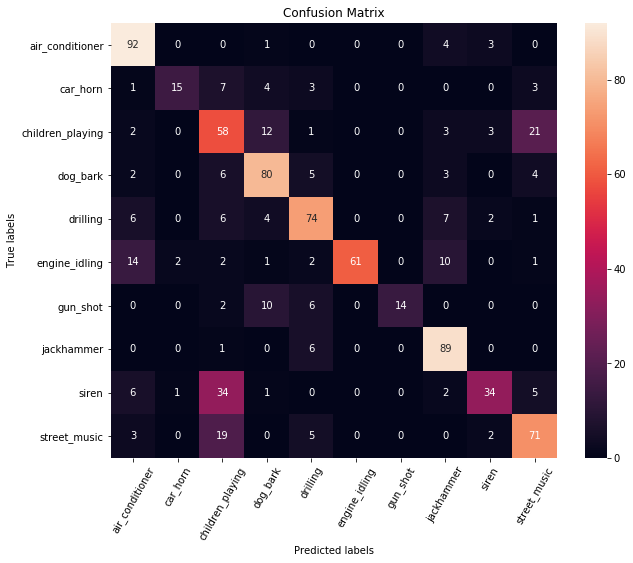

In [660]:
#import seaborn as sns
import matplotlib.pyplot as plt     

def plot_confusion(cm, classnames):

    fig, ax = plt.subplots(1, figsize=(10,8))
    sns.heatmap(cm, annot=True, ax=ax);

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classnames, rotation=60)
    ax.yaxis.set_ticklabels(classnames, rotation=0)

from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(val_d.classID, val_p, labels=None, sample_weight=None)
cm = confusion_matrix(t.classID, mean_m, labels=None, sample_weight=None)
plot_confusion(cm, urbansound8k.classnames)

In [536]:
data.groupby(['fold', 'class'])['classID'].count()

fold  class           
1     air_conditioner     100
      car_horn             36
      children_playing    100
      dog_bark            100
      drilling            100
      engine_idling        96
      gun_shot             35
      jackhammer          120
      siren                86
      street_music        100
2     air_conditioner     100
      car_horn             42
      children_playing    100
      dog_bark            100
      drilling            100
      engine_idling       100
      gun_shot             35
      jackhammer          120
      siren                91
      street_music        100
3     air_conditioner     100
      car_horn             43
      children_playing    100
      dog_bark            100
      drilling            100
      engine_idling       107
      gun_shot             36
      jackhammer          120
      siren               119
      street_music        100
                         ... 
8     air_conditioner     100
      car_horn   

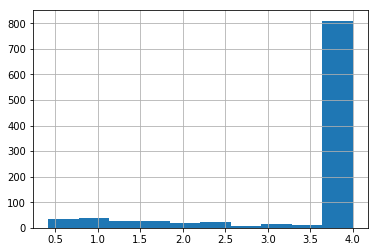

In [537]:
drilling = data[data['class'] == 'drilling']
(drilling.end - drilling.start).hist()

In [560]:
drilling.groupby('fold')['fsID'].unique().values

array([array([ 14113, 147764, 165642, 165645,  17913,  22962,  46669,  55020,
        57584,  71087,  78360,  96158]),
       array([104817, 118723, 165643, 180126, 185800,  34621,  46668,  50416,
        59594,  71080,  76086,  77751]),
       array([103199, 103357,  14115, 165786, 185801,  29721,  37560,  42937,
        63095,  66622,  69598,  95562]),
       array([128607, 140824,  14110, 144351, 151005, 156362, 165785, 169466,
       179212, 187377, 199929,  29722]),
       array([118440, 180125, 180128,  19007, 205874, 205878,  39533,  50413,
        71086,  71171,  77774,  84699]),
       array([107842,  14114, 165641, 166931, 167701, 179725,  24364,  34643,
        58005,  66623,  71079,  71088]),
       array([104625, 127443, 130961, 135849, 165644,  50415,  50629,    518,
        57696,  71529,  74965,  89099]),
       array([139000, 147019, 161129, 167702, 168037, 180132, 180134, 205610,
        42324,  59595,  76085,  96159]),
       array([127538, 137815,  14111, 146249, 18